In [65]:
import numpy as np 
import pandas as pd
import os, dicom, fnmatch, random, time, cv2

from sklearn import svm
from sklearn.metrics import precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.stats import entropy 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def chisquaredist(array1, array2):
    if len(array1) != len(array2):
        raise ValueError('Input arrays need to be the same size.')
    return sum([ ( (array1[i] - array2[i]) ** 2 ) / (array1[i] + array2[i]) for i in range(len(array1))])

def getFile(directory, ftype):
    matches = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, '*.'+ftype):
            matches.append(os.path.join(root, filename))
    return matches

def evalClustering(data, min_clust=2, max_clust=31):
    sil_score = []
    for n in range(min_clust, max_clust):
        kmeans = KMeans(n_clusters = n, random_state = 10)
        clt_lab = kmeans.fit_predict(data)
        sil_avg = silhouette_score(data, clt_lab)
        print('for {} clusters, sil score is {}'.format(n, sil_avg))
        sil_score.append(sil_avg)
    
    plt.plot(range(min_clust, max_clust), sil_score)
    plt.title('Average Silhouette Score Scree Plot', fontsize=14)
    ax = plt.axes()
    ax.set_xticks(range(min_clust, max_clust, round((max_clust-min_clust)/10)))
    ax.set_xlabel('Number of clusters (K)')
    ax.set_ylabel('Average Silhouette Score')
    return sil_score

def transformImg(features, centers):
    '''
    * features is a dictionary
    * centers is np array
    '''
    img_hist = {}
    for i in features:
        hist = np.zeros(len(centers))
        feat = features[i]['features']
        for f in feat:
            temp_sim = []
            for center in centers:
                temp_sim.append(euclidean(f, center))
            hist[temp_sim.index(max(temp_sim))] += 1
        img_hist[i] = hist
    return img_hist

def retrieve(train, test, labels):
    '''
    input two histogram represented dataset
    output L1, chi, kL results
    '''
    L1_results = {}
    chi_results = {}
    KL_results = {}
    for i in [1, 0]:
        L1_results[i] = []
        chi_results[i] = []
        KL_results[i] = []
    db_labels = [int(labels[labels.Image == i].Label) for i in train]
    for i in test:
        L1_r = []
        chi_r = []
        KL_r = []
        for j in train:
            query_hist = test[i]
            db_hist = train[j]
            L1_r.append(cityblock(query_hist, db_hist))
            chi_r.append(chisquaredist(query_hist, db_hist))
            KL_r.append(entropy(query_hist, db_hist))
        L1_output = [x for (y, x) in sorted(zip(L1_r, db_labels))]
        chi_output = [x for (y, x) in sorted(zip(chi_r, db_labels))]
        KL_output = [x for (y, x) in sorted(zip([1 if x == float('inf') else x for x in KL_r], db_labels))]
        
        curr_label = int(labels[labels.Image == i].Label)
        L1_results[curr_label].append(L1_output)
        chi_results[curr_label].append(chi_output)
        KL_results[curr_label].append(KL_output)
        
    return L1_results, chi_results, KL_results

def evaluate(d):
    MAP = {}
    MAR = {}
    for i in d:
        MAP[i], MAR[i] = [], []
    for i in d:
        map_temp = []
        mar_temp = []
        for j in d[i]:
            tp, fp, temp_pre, temp_rec = 0, 0, [], []
            for out in j:
                if out == i:
                    tp += 1
                else:
                    fp += 1
                temp_pre.append(tp/(tp+fp))
                temp_rec.append(tp/len(j))
            map_temp.append(mean(temp_pre))
            mar_temp.append(mean(temp_rec))
        MAP[i] = mean(map_temp)
        MAR[i] = mean(mar_temp)
    return MAP, MAR

def displayResults(P, R):
    to_display, p, r = [], [], []
    for (k, v), (k2, v2) in zip(P.items(), R.items()):
        to_display.append([k, v, v2])
        p.append(v)
        r.append(v2)
    to_display.append(['Average', mean(p), mean(r)])
    return pd.DataFrame(to_display, columns=['Type', 'Precision', 'Recall'])

def mean(arr):
    return sum(arr)/len(arr)

In [3]:
labels = pd.read_excel('LIDC_Label.xlsx')
with_nod = labels[labels.Label == 1]
without_nod = labels[labels.Label == 0]

In [4]:
print(with_nod.shape[0])
print(without_nod.shape[0])

137
1715


#### Split training and testing

for no_nod, random sample 13 slices per patient

In [5]:
nod = with_nod.Image.values
no_nod = without_nod.Image.values

In [6]:
nod_train = random.sample(list(nod), 127)
nod_query = list(set(nod) - set(nod_train))

In [7]:
no_nod_subset = []
by_patient = {}
for dcm in no_nod:
    if dcm[20:24] not in by_patient:
        by_patient[dcm[20:24]] = []
        by_patient[dcm[20:24]].append(dcm)
    else:
        by_patient[dcm[20:24]].append(dcm)
for i in by_patient:
    no_nod_subset+= random.sample(by_patient[i], 14)
print(len(no_nod_subset))

140


In [8]:
no_nod_subset[0]

'LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192/000020.dcm'

In [9]:
no_nod_subset_train = random.sample(no_nod_subset, 130)
no_nod_subset_query = list(set(no_nod_subset) - set(no_nod_subset_train))

In [10]:
print("Nodule training: {}".format(len(nod_train)))
print("Nodule query: {}".format(len(nod_query)))
print("No nodule training: {}".format(len(no_nod_subset_train)))
print("No nodule query: {}".format(len(no_nod_subset_query)))

Nodule training: 127
Nodule query: 10
No nodule training: 130
No nodule query: 10


In [11]:
nod_train = [x.replace('.dcm', '.jpg') for x in nod_train]

In [12]:
train = [x.replace('.jpg', '.dcm') for x in nod_train] + no_nod_subset_train
query = nod_query + no_nod_subset_query

#### Generate SIFT

##### With nodules

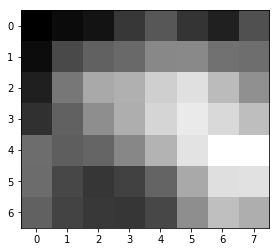

In [13]:
plt.imshow(cv2.cvtColor(cv2.imread(nod_train[0]), cv2.COLOR_BGR2GRAY), cmap='gray')

In [14]:
start = time.time()
SIFT = {}
for nod in nod_train:
    image = cv2.cvtColor(cv2.imread(nod), cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
    kp, feat = sift.detectAndCompute(image, None)
    SIFT[nod] = {}
    SIFT[nod]['keypoints'] = kp
    SIFT[nod]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 0.10750222206115723 seconds


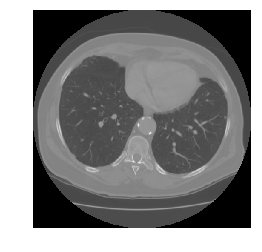

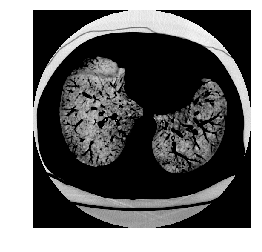

(-0.5, 511.5, 511.5, -0.5)

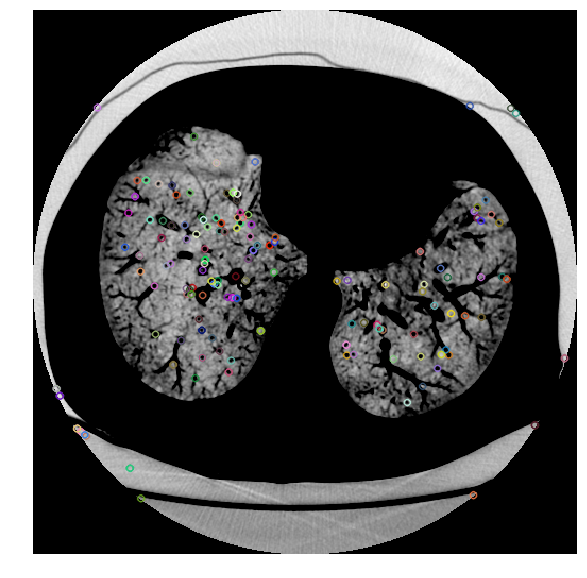

In [18]:
img = dicom.read_file(no_nod_subset_train[0]).pixel_array
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

cvuint8 = cv2.convertScaleAbs(img)
plt.imshow(255-cvuint8, cmap='gray')
plt.axis('off')
plt.show()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
kp, feat = sift.detectAndCompute(255-cvuint8, None)
img2=cv2.drawKeypoints(255-cvuint8, kp, img)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img2, cmap='gray')
ax.axis('off')

##### Without nodules

In [19]:
start = time.time()
for dcm in no_nod_subset_train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    SIFT[dcm] = {}
    SIFT[dcm]['keypoints'] = kp
    SIFT[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 16.33417582511902 seconds


In [20]:
SIFT_feat = np.empty((1, 128))
for i in SIFT:
    try:
        SIFT_feat = np.concatenate([SIFT_feat, SIFT[i]['features']])
    except:
        print(i)
        continue
SIFT_feat = np.delete(SIFT_feat, 0, 0)

LIDC-IDRI/LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264/000051.jpg
LIDC-IDRI/LIDC-IDRI-0002/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/000135.jpg
LIDC-IDRI/LIDC-IDRI-0007/1.3.6.1.4.1.14519.5.2.1.6279.6001.280315210397549164238230581781/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680/000034.jpg
LIDC-IDRI/LIDC-IDRI-0009/1.3.6.1.4.1.14519.5.2.1.6279.6001.225213110794629789874295007045/1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210/000043.jpg
LIDC-IDRI/LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264/000002.jpg
LIDC-IDRI/LIDC-IDRI-0010/1.3.6.1.4.1.14519.5.2.1.6279.6001.303099231937480740934110243375/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796/000016.jpg
LIDC

In [21]:
SIFT_feat.shape

(26575, 128)

### All training and query images (whole CT scans for those having nodules)

In [23]:
train_images = {}
start = time.time()
for dcm in train:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    train_images[dcm] = {}
    train_images[dcm]['keypoints'] = kp
    train_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 30.61492395401001 seconds


In [24]:
len(train_images.keys())

257

In [25]:
query_images = {}
start = time.time()
for dcm in query:
    dicom_file = dicom.read_file(dcm)
    CT = 255-cv2.convertScaleAbs(dicom_file.pixel_array)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
    kp, feat = sift.detectAndCompute(np.uint8(CT), None)
    query_images[dcm] = {}
    query_images[dcm]['keypoints'] = kp
    query_images[dcm]['features'] = feat
end = time.time()
print('Time taken: {} seconds'.format(end-start))

Time taken: 2.408215045928955 seconds


### Clustering

for 2 clusters, sil score is 0.1892776489153831
for 3 clusters, sil score is 0.17805169431952853
for 4 clusters, sil score is 0.16249336765446104
for 5 clusters, sil score is 0.16021929460079862
for 6 clusters, sil score is 0.16648835913713173
for 7 clusters, sil score is 0.1666841699734115
for 8 clusters, sil score is 0.16226847087255666
for 9 clusters, sil score is 0.15348392484459217
for 10 clusters, sil score is 0.14881409565432585
for 11 clusters, sil score is 0.1627562563949995
for 12 clusters, sil score is 0.15845822681968688
for 13 clusters, sil score is 0.15265850459321076
for 14 clusters, sil score is 0.15510933802622015
for 15 clusters, sil score is 0.1479550650871136
for 16 clusters, sil score is 0.15455310286081536
for 17 clusters, sil score is 0.15187980983457924
for 18 clusters, sil score is 0.15198104981659472
for 19 clusters, sil score is 0.14604077637166504
for 20 clusters, sil score is 0.1403141465200111
for 21 clusters, sil score is 0.13788050891556777
for 22 cluste

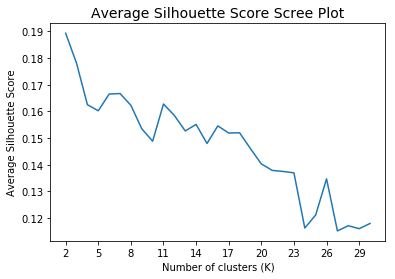

In [26]:
sil_score = evalClustering(SIFT_feat, max_clust=31)

In [27]:
kmeans = KMeans(n_clusters=7, random_state=10).fit(SIFT_feat)
centers = kmeans.cluster_centers_

In [28]:
np.bincount(kmeans.labels_)

array([1780, 2933, 4178, 6816, 2034, 6254, 2580])

### Transform Images

In [29]:
database = transformImg(train_images, centers)

In [30]:
len(database.keys())

257

In [31]:
queryHist = transformImg(query_images, centers)

In [32]:
len(queryHist.keys())

20

In [33]:
labels.head()

,Image,Label
0,LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2...,0
1,LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2...,0
2,LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2...,1
3,LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2...,0
4,LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2...,0


In [34]:
L1_labels, chi_labels, KL_labels = retrieve(database, queryHist, labels)

/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [35]:
L1_labels.keys()

dict_keys([1, 0])

In [36]:
L1_MAP, L1_MAR = evaluate(L1_labels)
chi_MAP, chi_MAR = evaluate(chi_labels)
KL_MAP, KL_MAR = evaluate(KL_labels)

In [37]:
displayResults(L1_MAP, L1_MAR)

,Type,Precision,Recall
0,1,0.601026,0.289823
1,0,0.599748,0.289049
2,Average,0.600387,0.289436


In [38]:
displayResults(chi_MAP, chi_MAR)

,Type,Precision,Recall
0,1,0.810371,0.363106
1,0,0.331417,0.190422
2,Average,0.570894,0.276764


In [39]:
displayResults(KL_MAP, KL_MAR)

,Type,Precision,Recall
0,1,0.551304,0.262027
1,0,0.620287,0.304963
2,Average,0.585796,0.283495


#### Try SVM

In [41]:
clf = svm.SVC()

In [51]:
y = []
for i in database:
    y.append(int(labels[labels.Image == i].Label))

In [56]:
clf.fit(np.array(list(database.values())), y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
pred_label = clf.predict(np.array(list(queryHist.values())))

In [63]:
true_label = []
for i in queryHist:
    true_label.append(int(labels[labels.Image == i].Label))

In [72]:
print(precision_score(true_label, pred_label, average=None))
print(recall_score(true_label, pred_label, average=None))

[ 0.69230769  0.85714286]
[ 0.9  0.6]


In [73]:
print(precision_score(true_label, pred_label))
print(recall_score(true_label, pred_label))

0.857142857143
0.6
